In [1]:
import torch 
import torch.nn as nn
import lightning.pytorch as pl
from models import *
import numpy as np
import matplotlib.pyplot as plt
from data.lightning_sasa import SASADataModule, SASADataConfig
from scipy.stats import pearsonr, spearmanr
import matplotlib as mpl

mpl.rcParams['figure.dpi'] = 500

In [2]:
baseline_model = SASABaseline().load_from_checkpoint('../chkpnts/baseline_2/checkpoints/epoch=22-step=3496.ckpt')
baseline_model.freeze()
baseline_model.eval()
baseline_model = baseline_model.cuda()

In [3]:
baseline_model_10 = SASABaseline().load_from_checkpoint('../chkpnts/baseline_10/epoch=29-step=4560.ckpt')
baseline_model_10.freeze()
baseline_model_10.eval()
baseline_model_10 = baseline_model_10.cuda()

In [4]:
baseline_model_3 = SASABaseline().load_from_checkpoint('../chkpnts/baseline_3/epoch=24-step=3800.ckpt')
baseline_model_3.freeze()
baseline_model_3.eval()
baseline_model_3 = baseline_model_3.cuda()

In [5]:
config = SASADataConfig(data_dir="../data/sasa", embedding_path="../data/sasa/sasaembeddings.h5", num_workers=8, num_classes=10, np_path="../data/sasa")
data_module = SASADataModule(config=config)
data_module.setup("fit")

Data preparation already done!


In [6]:
for p in baseline_model.parameters():
    param = p.detach().cpu().numpy().squeeze()
    break

In [7]:
param[402]

-0.73802704

In [8]:
x = np.argsort(param)[::-1][:5]
x

array([966, 188, 783, 411, 335])

In [9]:
import h5py
from data.fasta import Fasta
emb = h5py.File('../data/sasa/sasaembeddings.h5', 'r')
val = Fasta('../data/sasa/val.o')
emb_dict = {}
for header in val.get_headers():
    emb_dict[header] = emb[header.replace("-", "_") if "-" in header else header][()]


In [10]:
sasa = []
for header in val.get_headers():
    sasa.extend(val[header][1])

In [11]:
all_labels = np.concatenate(data_module.val_dataset.y)
mask = np.where(all_labels == -1.0)[0]
all_labels = np.delete(all_labels, mask)
all_emb = np.concatenate(data_module.val_dataset.X)
all_emb = np.delete(all_emb, mask, axis=0)

In [12]:
sasa_np = np.delete(np.array(sasa), mask)

In [13]:
assert sasa_np.shape == all_labels.shape 

In [14]:
t = "3i4g-A"
t_emb = emb_dict[t]
t_sasa = np.array(val[t][1])
mask = np.where(t_sasa == 0.0)[0]
t_sasa = np.delete(t_sasa, mask)
t_emb = np.delete(t_emb, mask, axis=0)

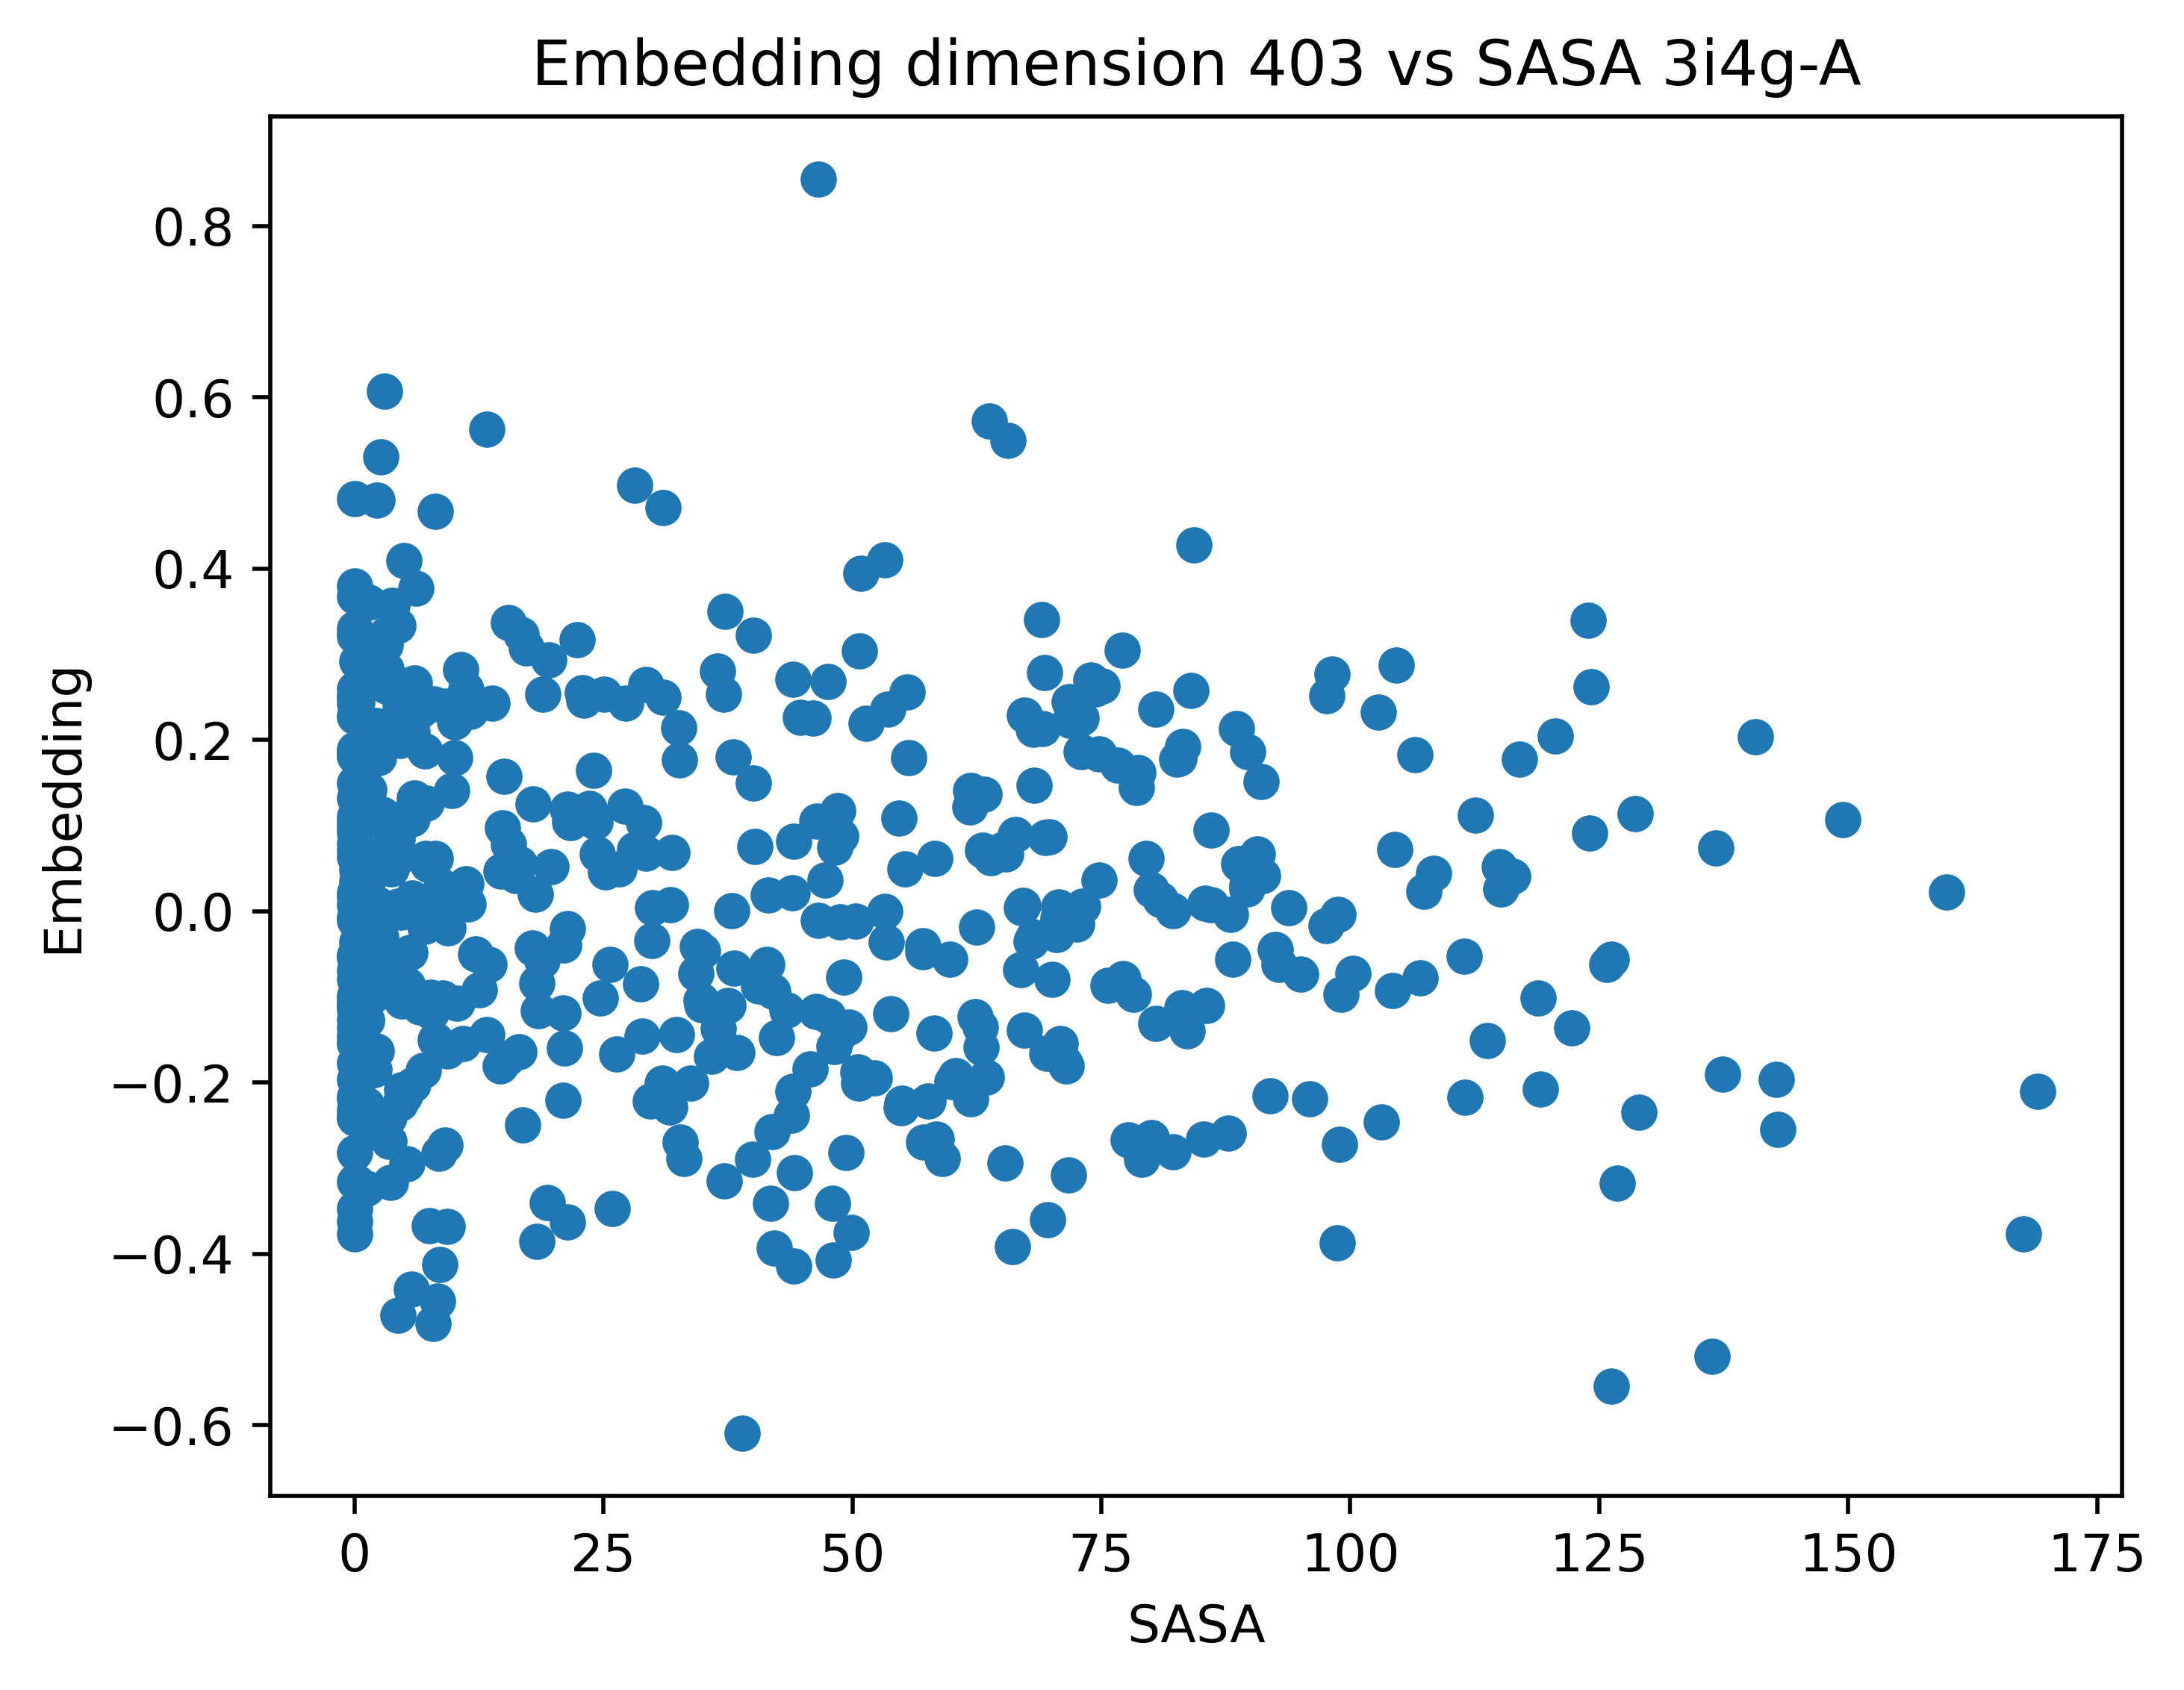

In [15]:
plt.plot(t_sasa, t_emb[:, 403], 'o')
plt.xlabel('SASA')
plt.ylabel('Embedding')
plt.title('Embedding dimension 403 vs SASA 3i4g-A')
plt.show()

In [16]:
from scipy.stats import spearmanr, pearsonr
spearmanr(t_sasa, t_emb[:, 294], )[0]

-0.23602709686840842

In [17]:
def f(input):
    return baseline_model_10(input).squeeze()

In [18]:
t_y = data_module.val_dataset.y[44]
t_y = np.delete(t_y, mask)

In [19]:
from captum.attr import IntegratedGradients
ig = IntegratedGradients(f)
attr = ig.attribute(torch.from_numpy(t_emb).type(torch.FloatTensor).requires_grad_().cuda(), target=torch.from_numpy(t_y).type(torch.LongTensor).cuda())
attr = attr.detach().cpu().numpy()

In [20]:
attr_mean = np.mean(attr, axis=0)

In [21]:
x = np.argsort(np.abs(attr_mean))[::-1][:10]
x

array([294,  22, 402, 437, 835, 356, 466, 189, 357, 188])

In [22]:
corr = [spearmanr(t_sasa, t_emb[:, i])[0] for i in x]
p_value = [spearmanr(t_sasa, t_emb[:, i])[1] for i in x]

In [23]:
from statsmodels.stats.multitest import multipletests
adjust_pvalues = multipletests(p_value, alpha=0.05, method='fdr_bh')[1]

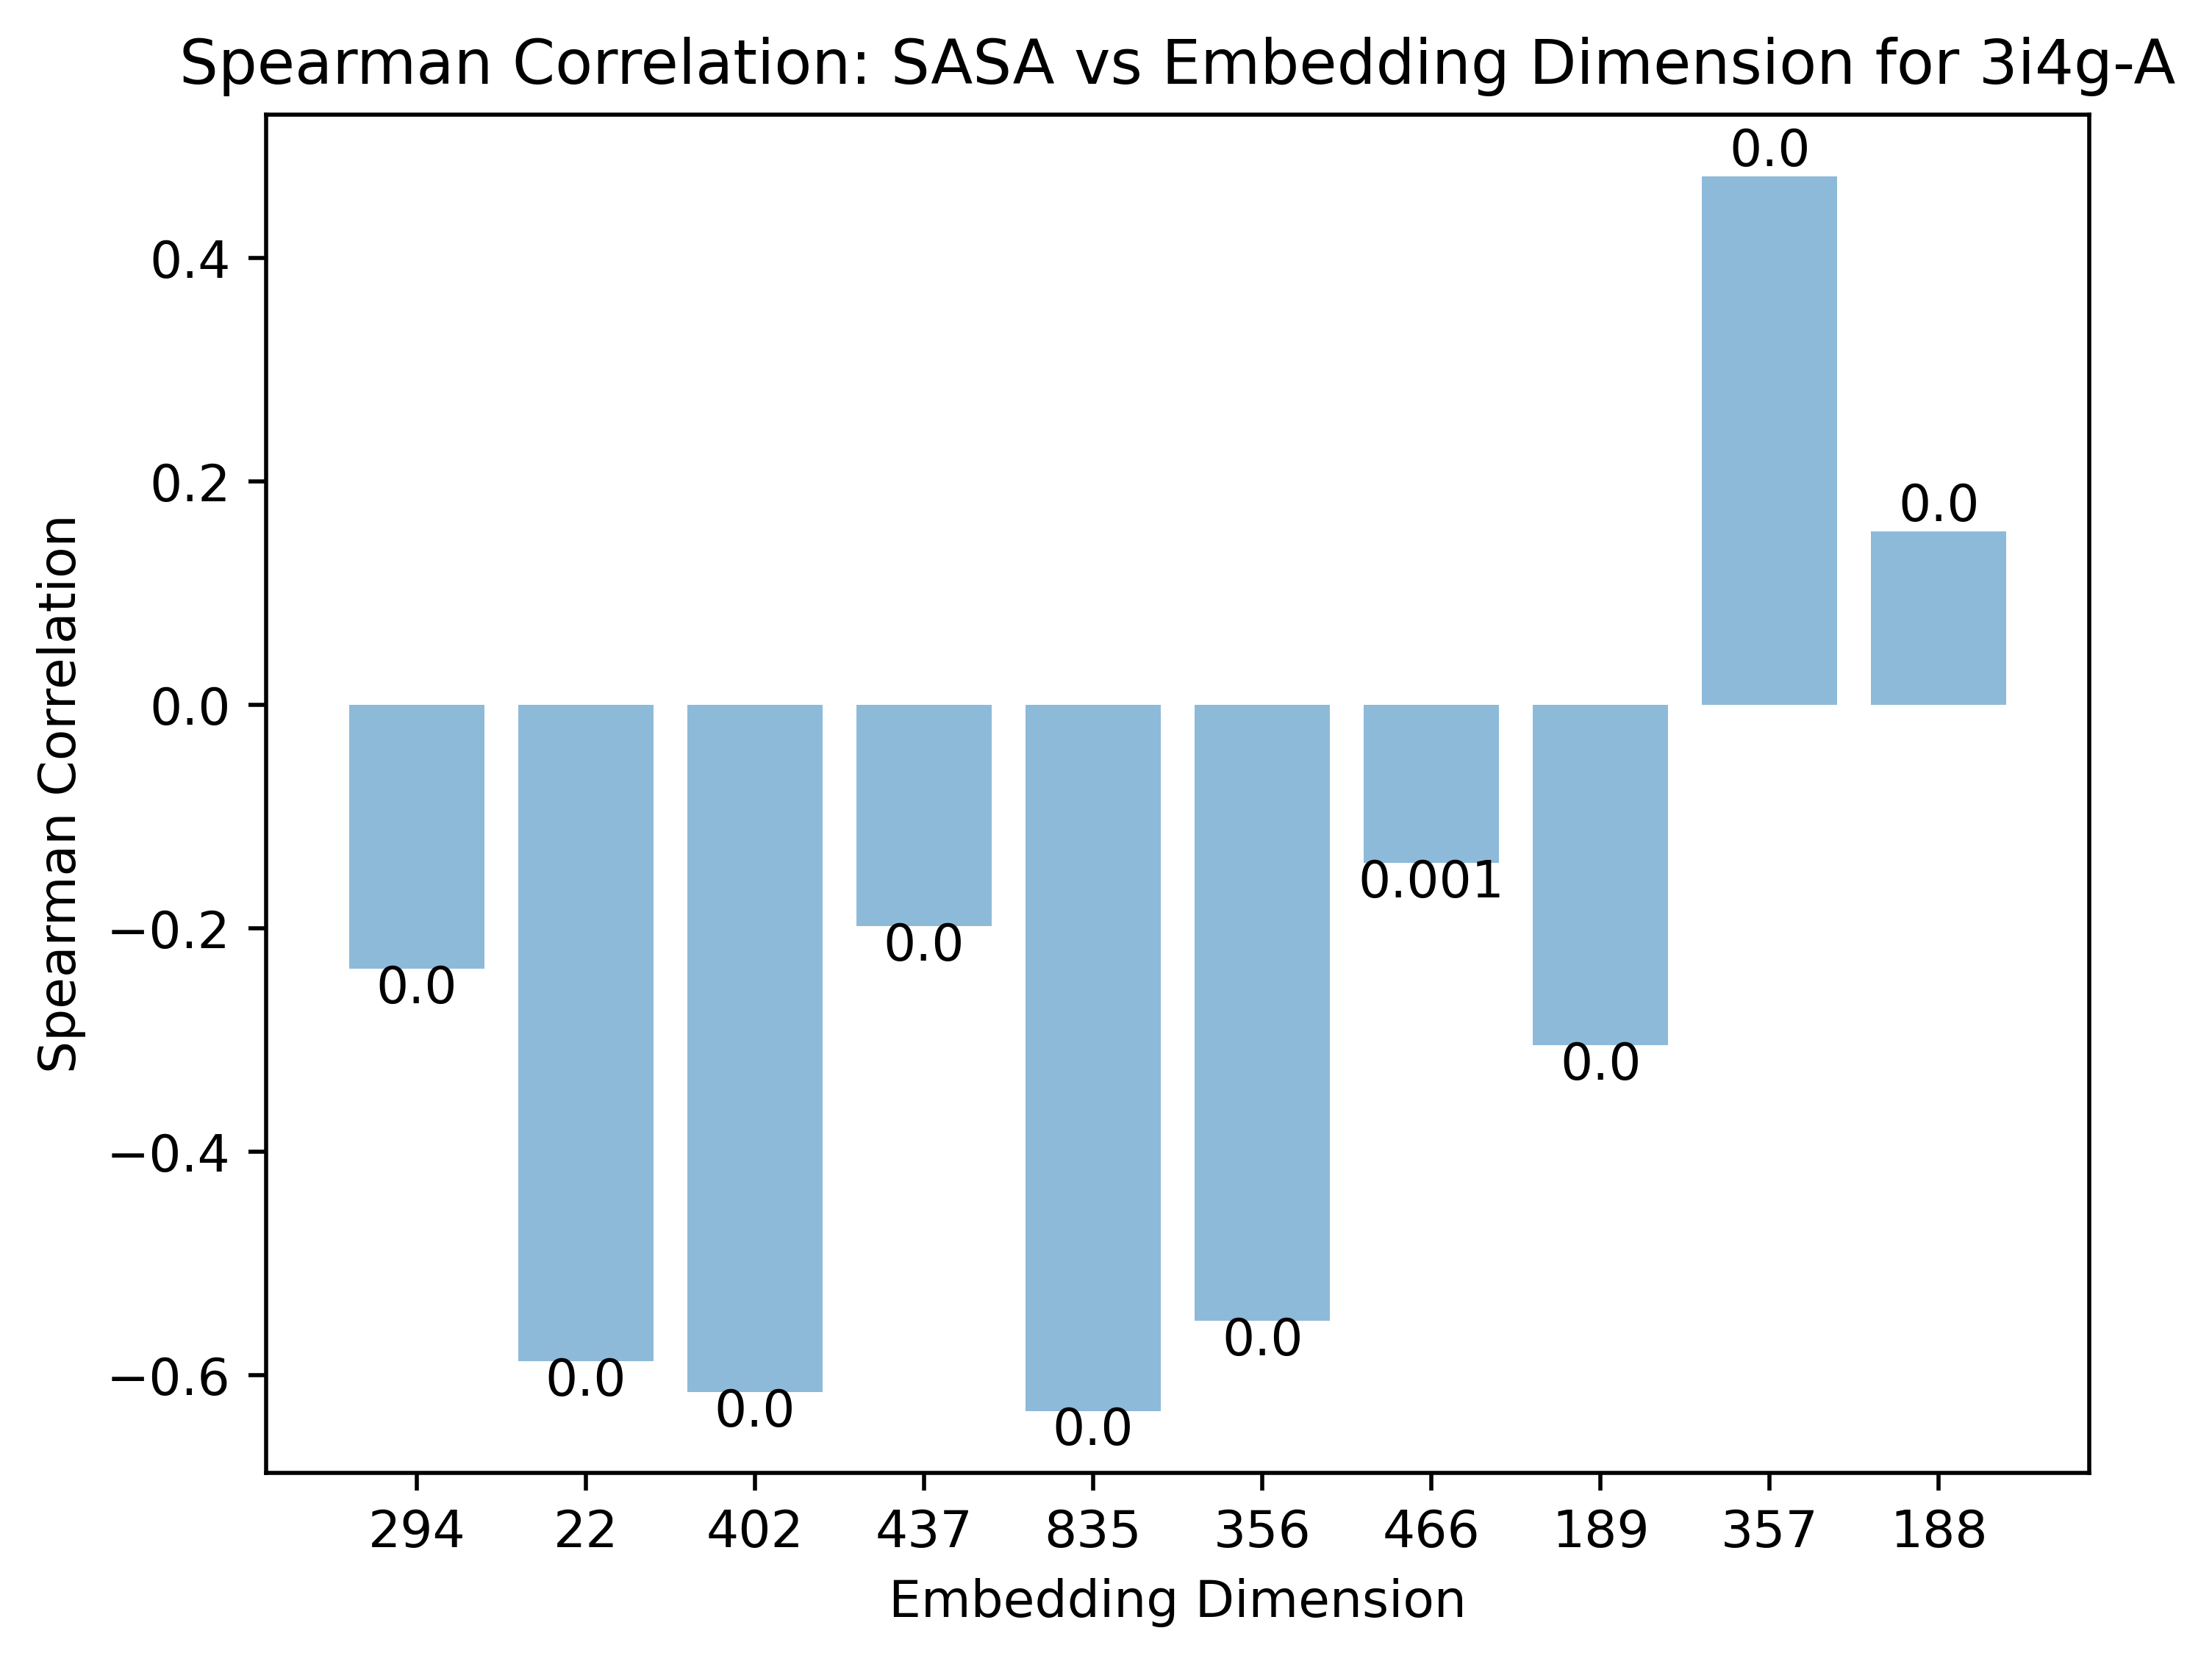

In [24]:
x_pos = np.arange(len(corr))
plt.xticks(x_pos, x, wrap=True)
bar = plt.bar(x_pos, corr, align='center', alpha=0.5)
for i, rect in enumerate(bar):
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2.0, height if height > 0 else height - 0.04, f'{int(adjust_pvalues[i] * 1000) / 1000}', ha='center', va='bottom')

plt.xlabel('Embedding Dimension')
plt.ylabel('Spearman Correlation')
plt.title('Spearman Correlation: SASA vs Embedding Dimension for 3i4g-A')
plt.show()


In [25]:
u, counts = np.unique(np.concatenate(data_module.val_dataset.y), return_counts=True)

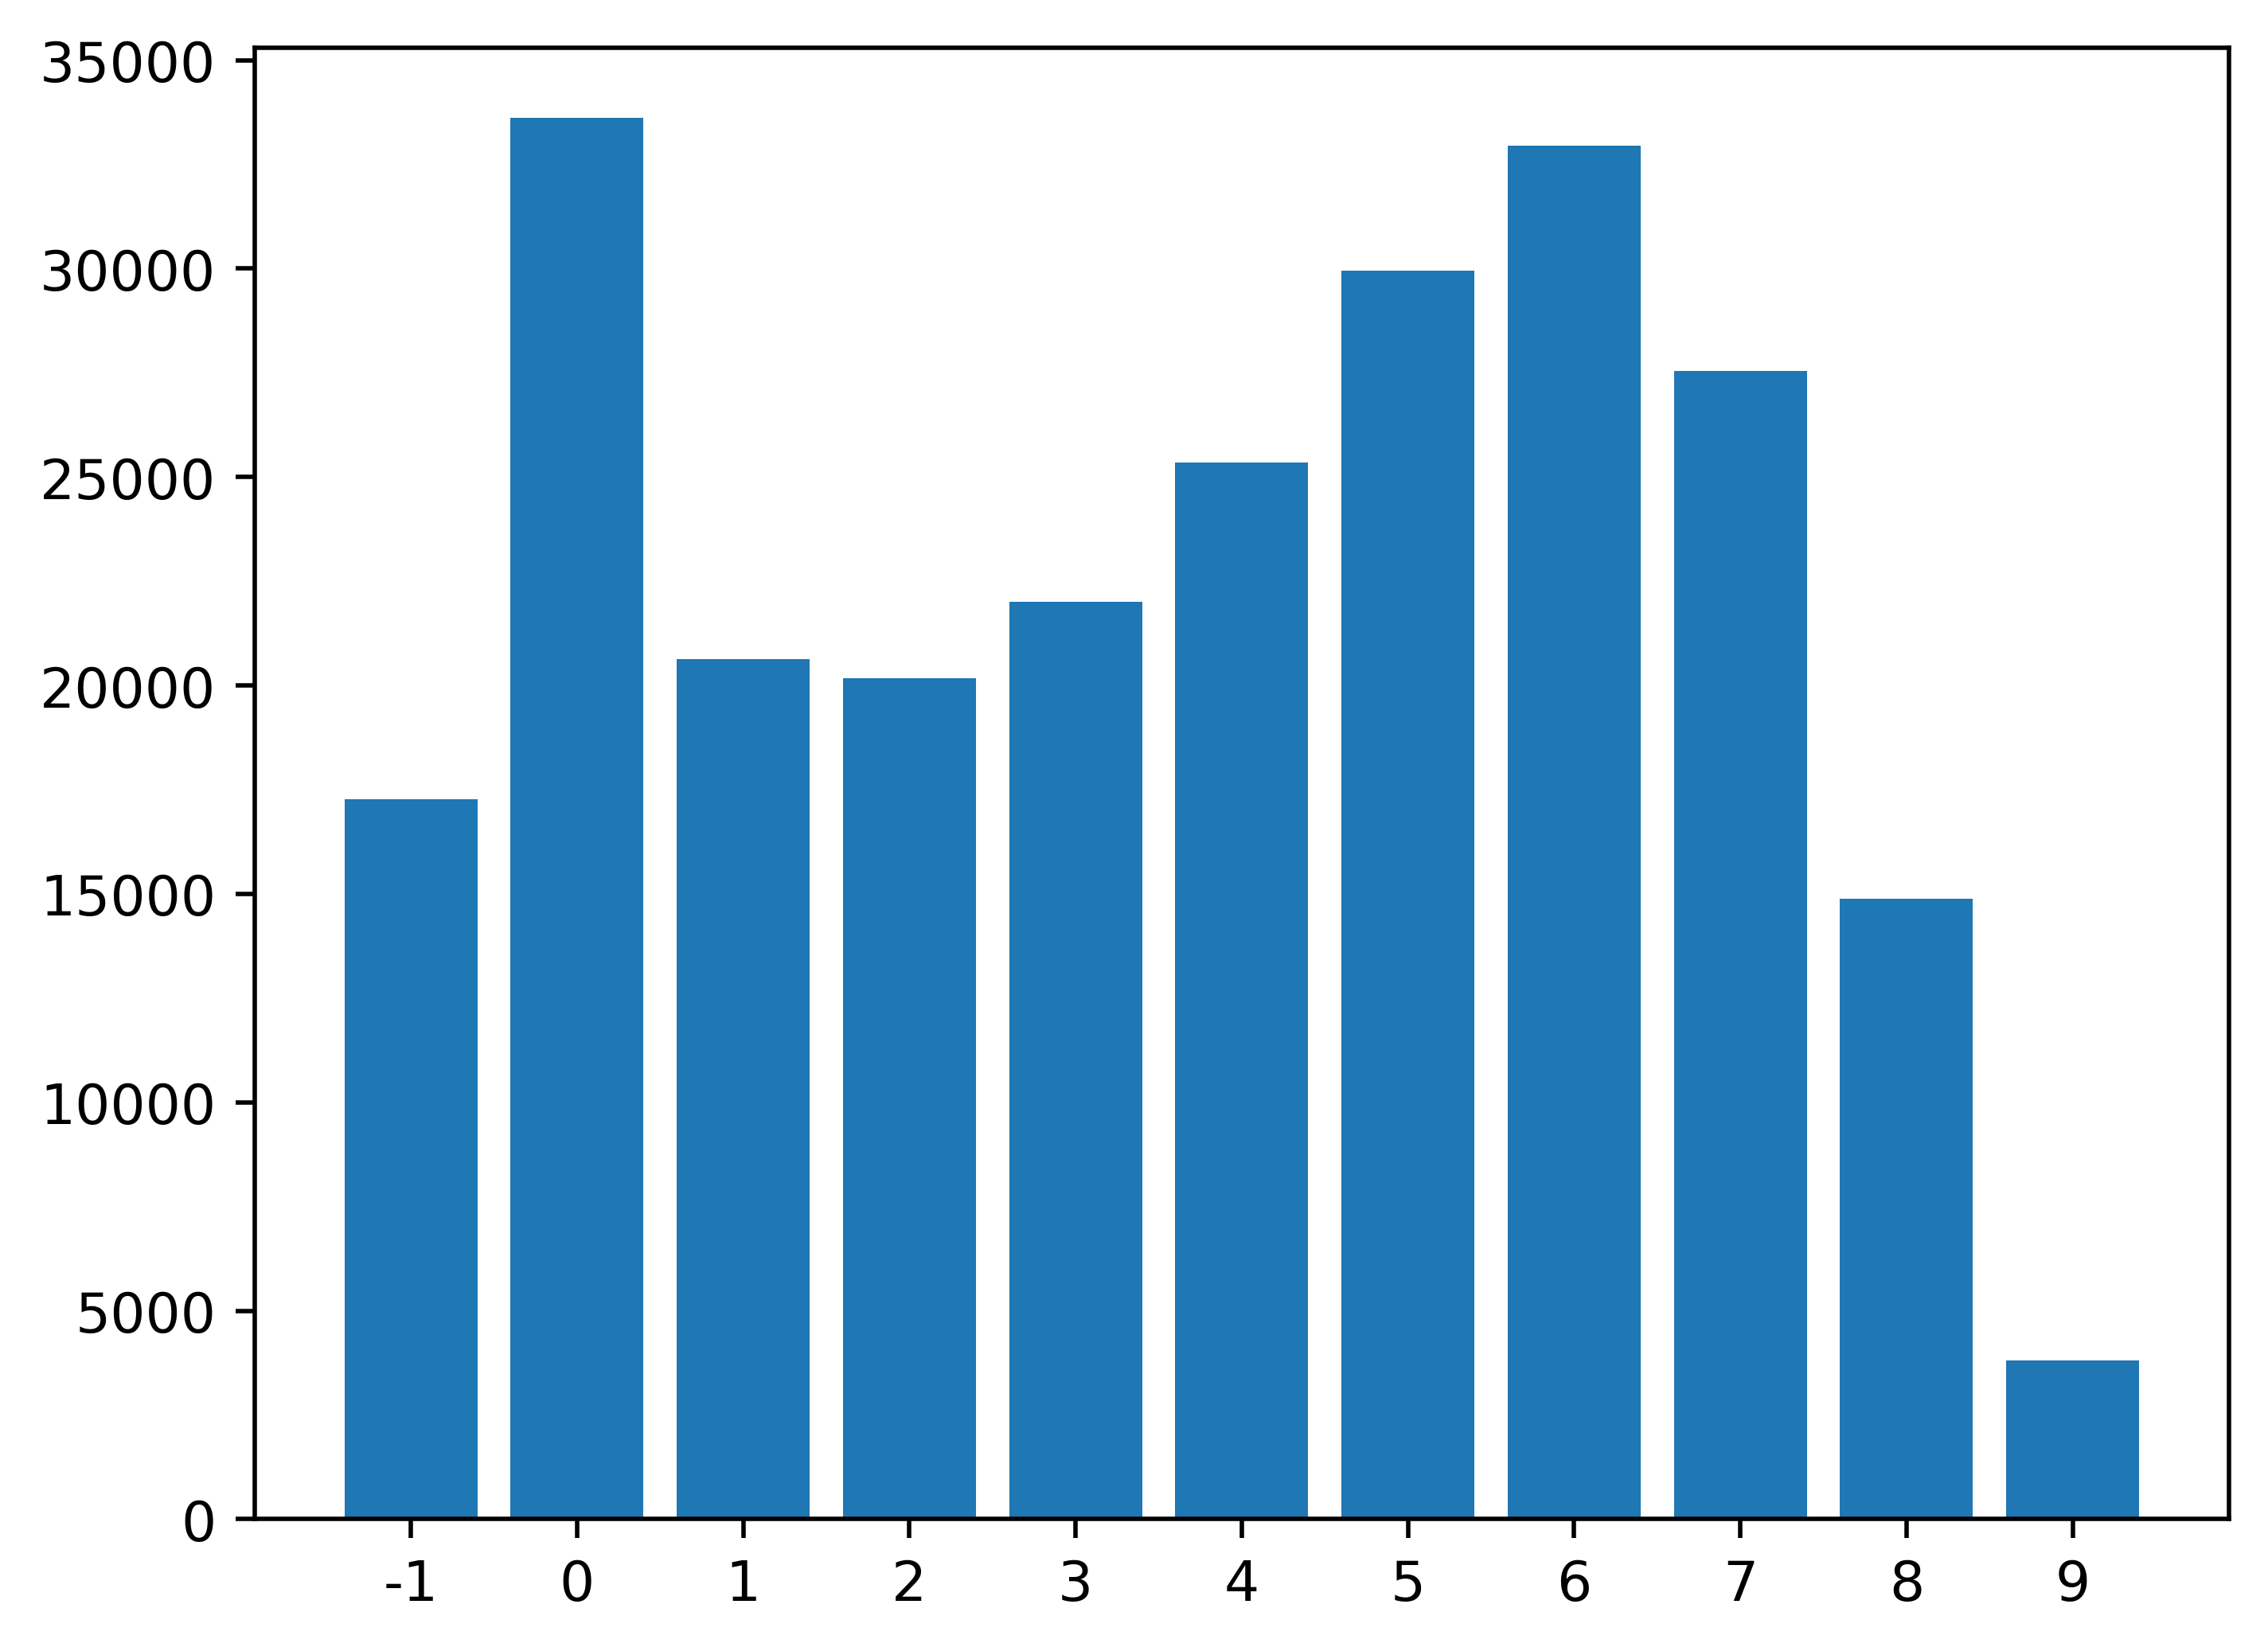

In [26]:
x_pos = np.arange(len(u))
plt.bar(x_pos, counts, align='center')
plt.xticks(x_pos, u, wrap=True)
plt.show()

### Feature Importance for 10 class Baseline Model

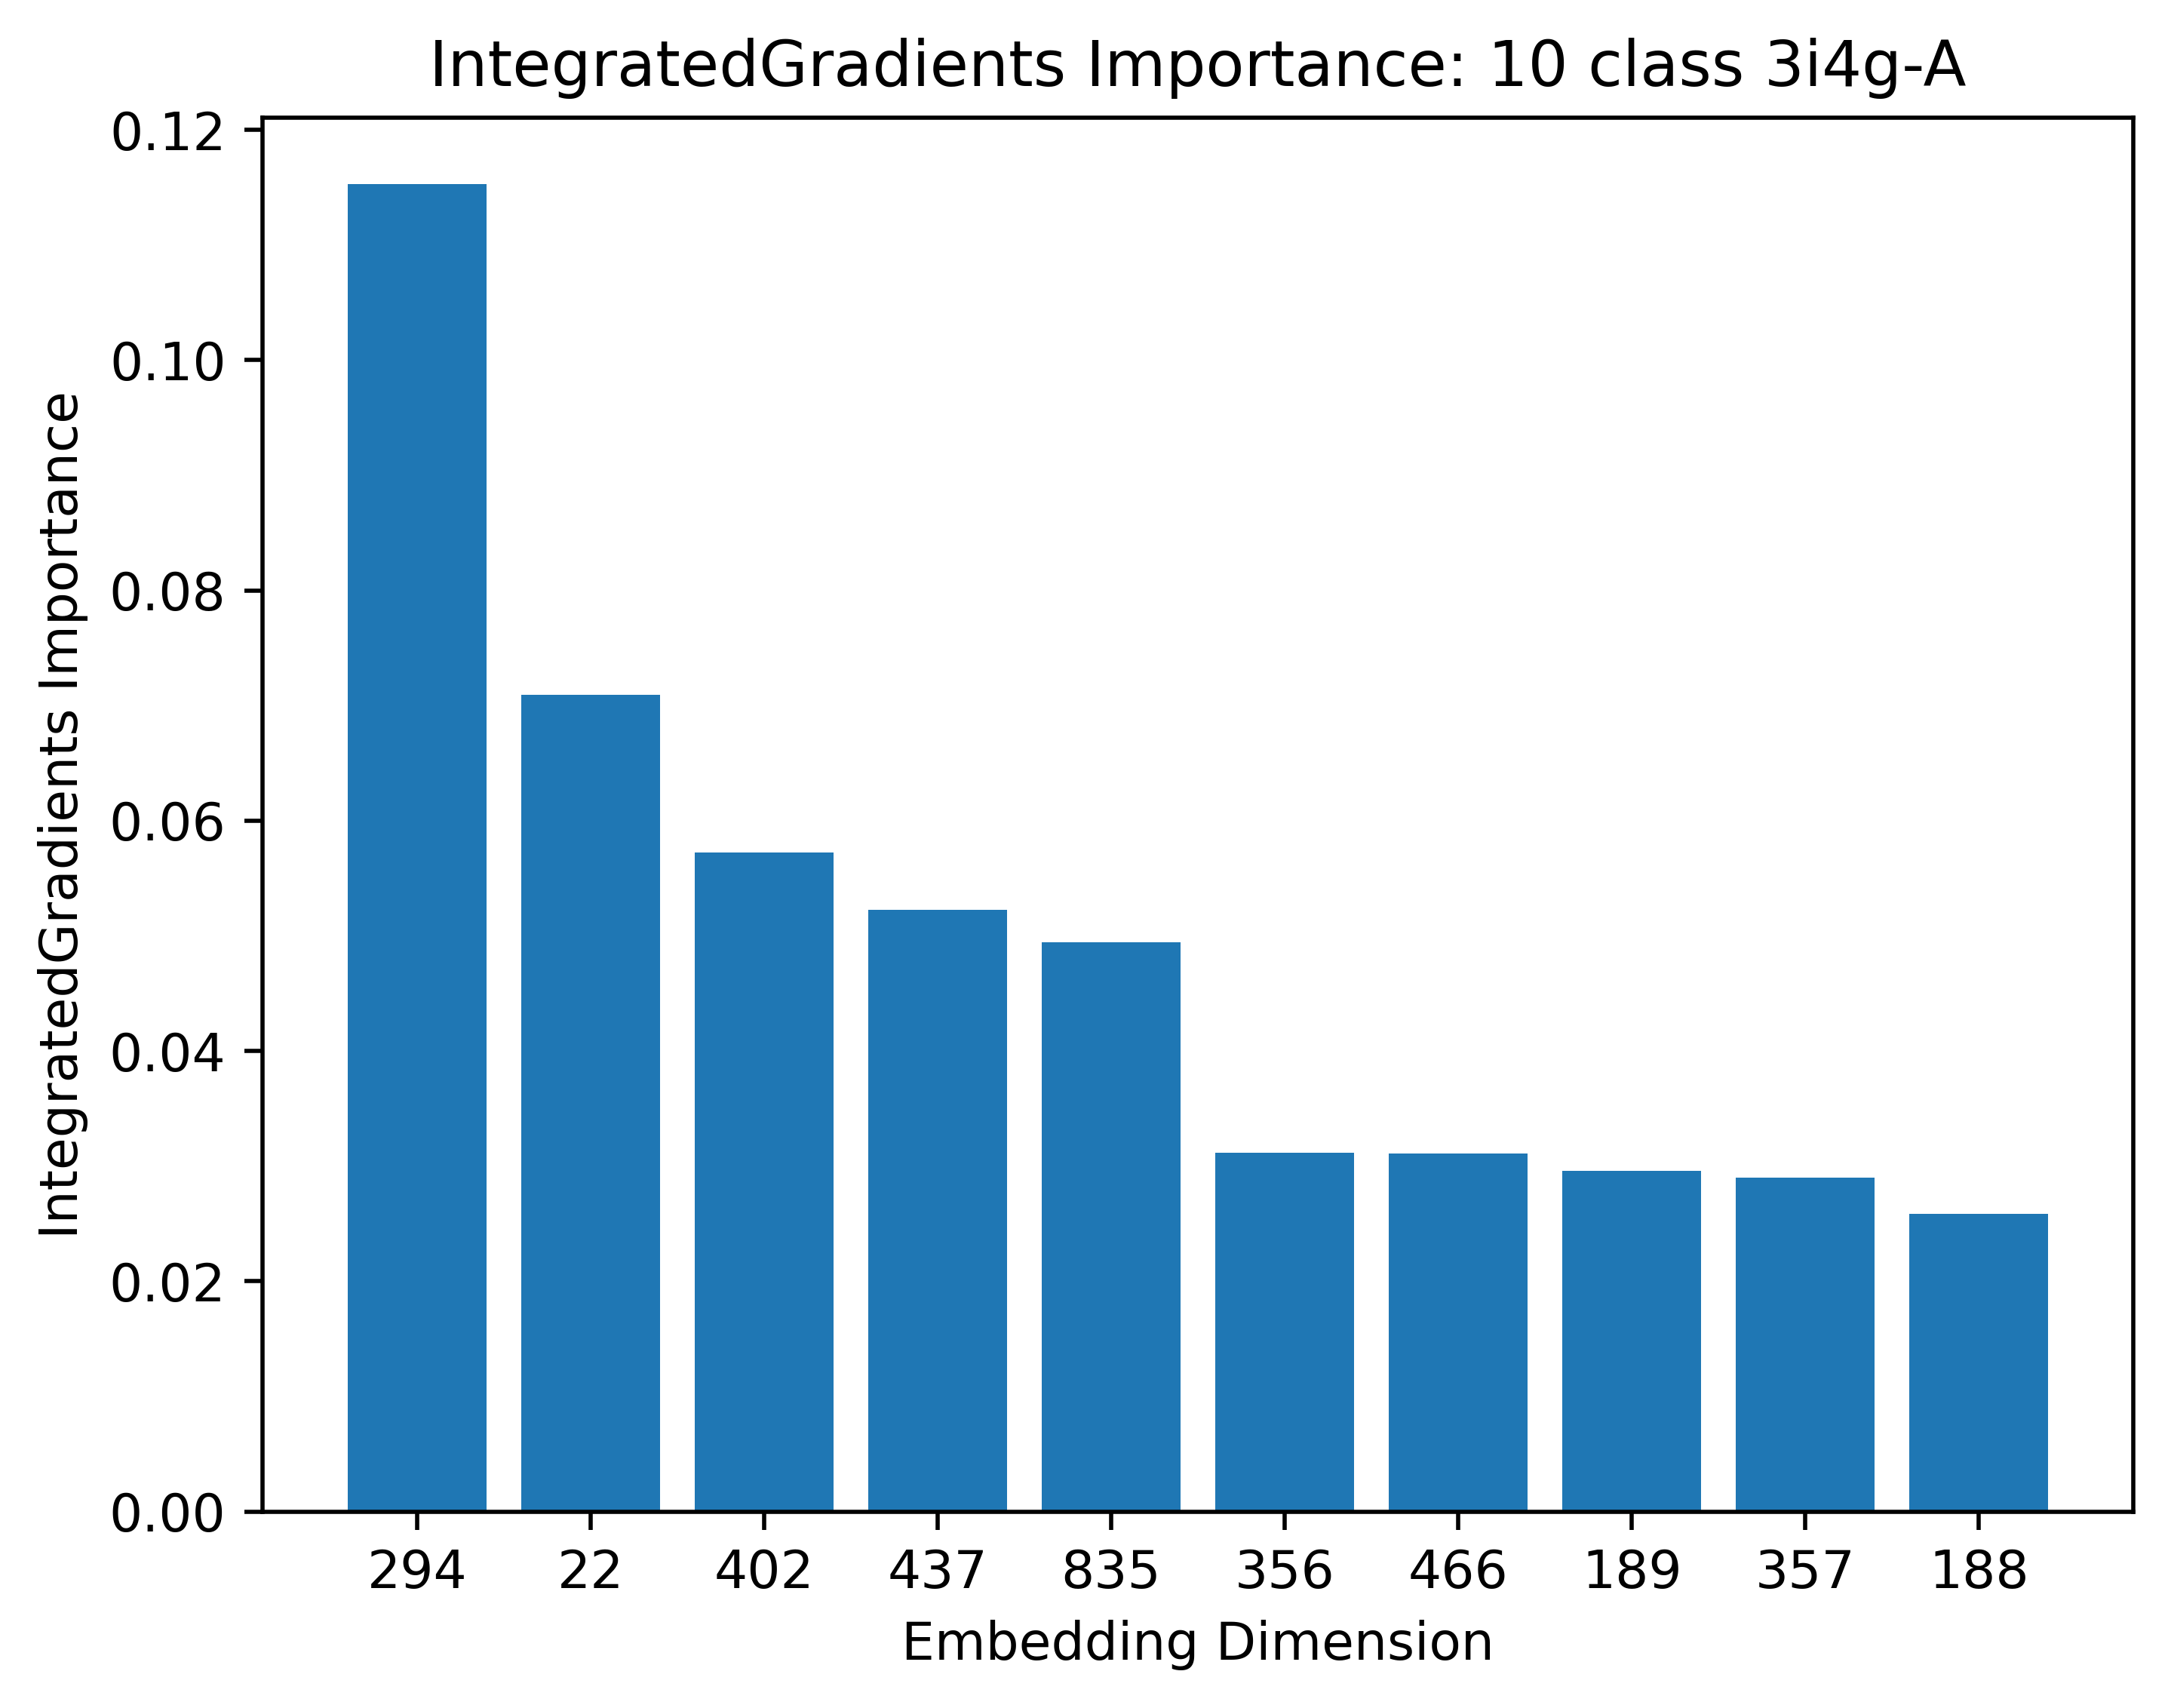

In [27]:
x_pos = np.arange(len(x))
plt.bar(x_pos, attr_mean[x], align='center')
plt.xticks(x_pos, x, wrap=True)
plt.xlabel('Embedding Dimension')
plt.ylabel('IntegratedGradients Importance')
plt.title('IntegratedGradients Importance: 10 class 3i4g-A')
plt.show()

### Feature Importance for 3 class Baseline Model

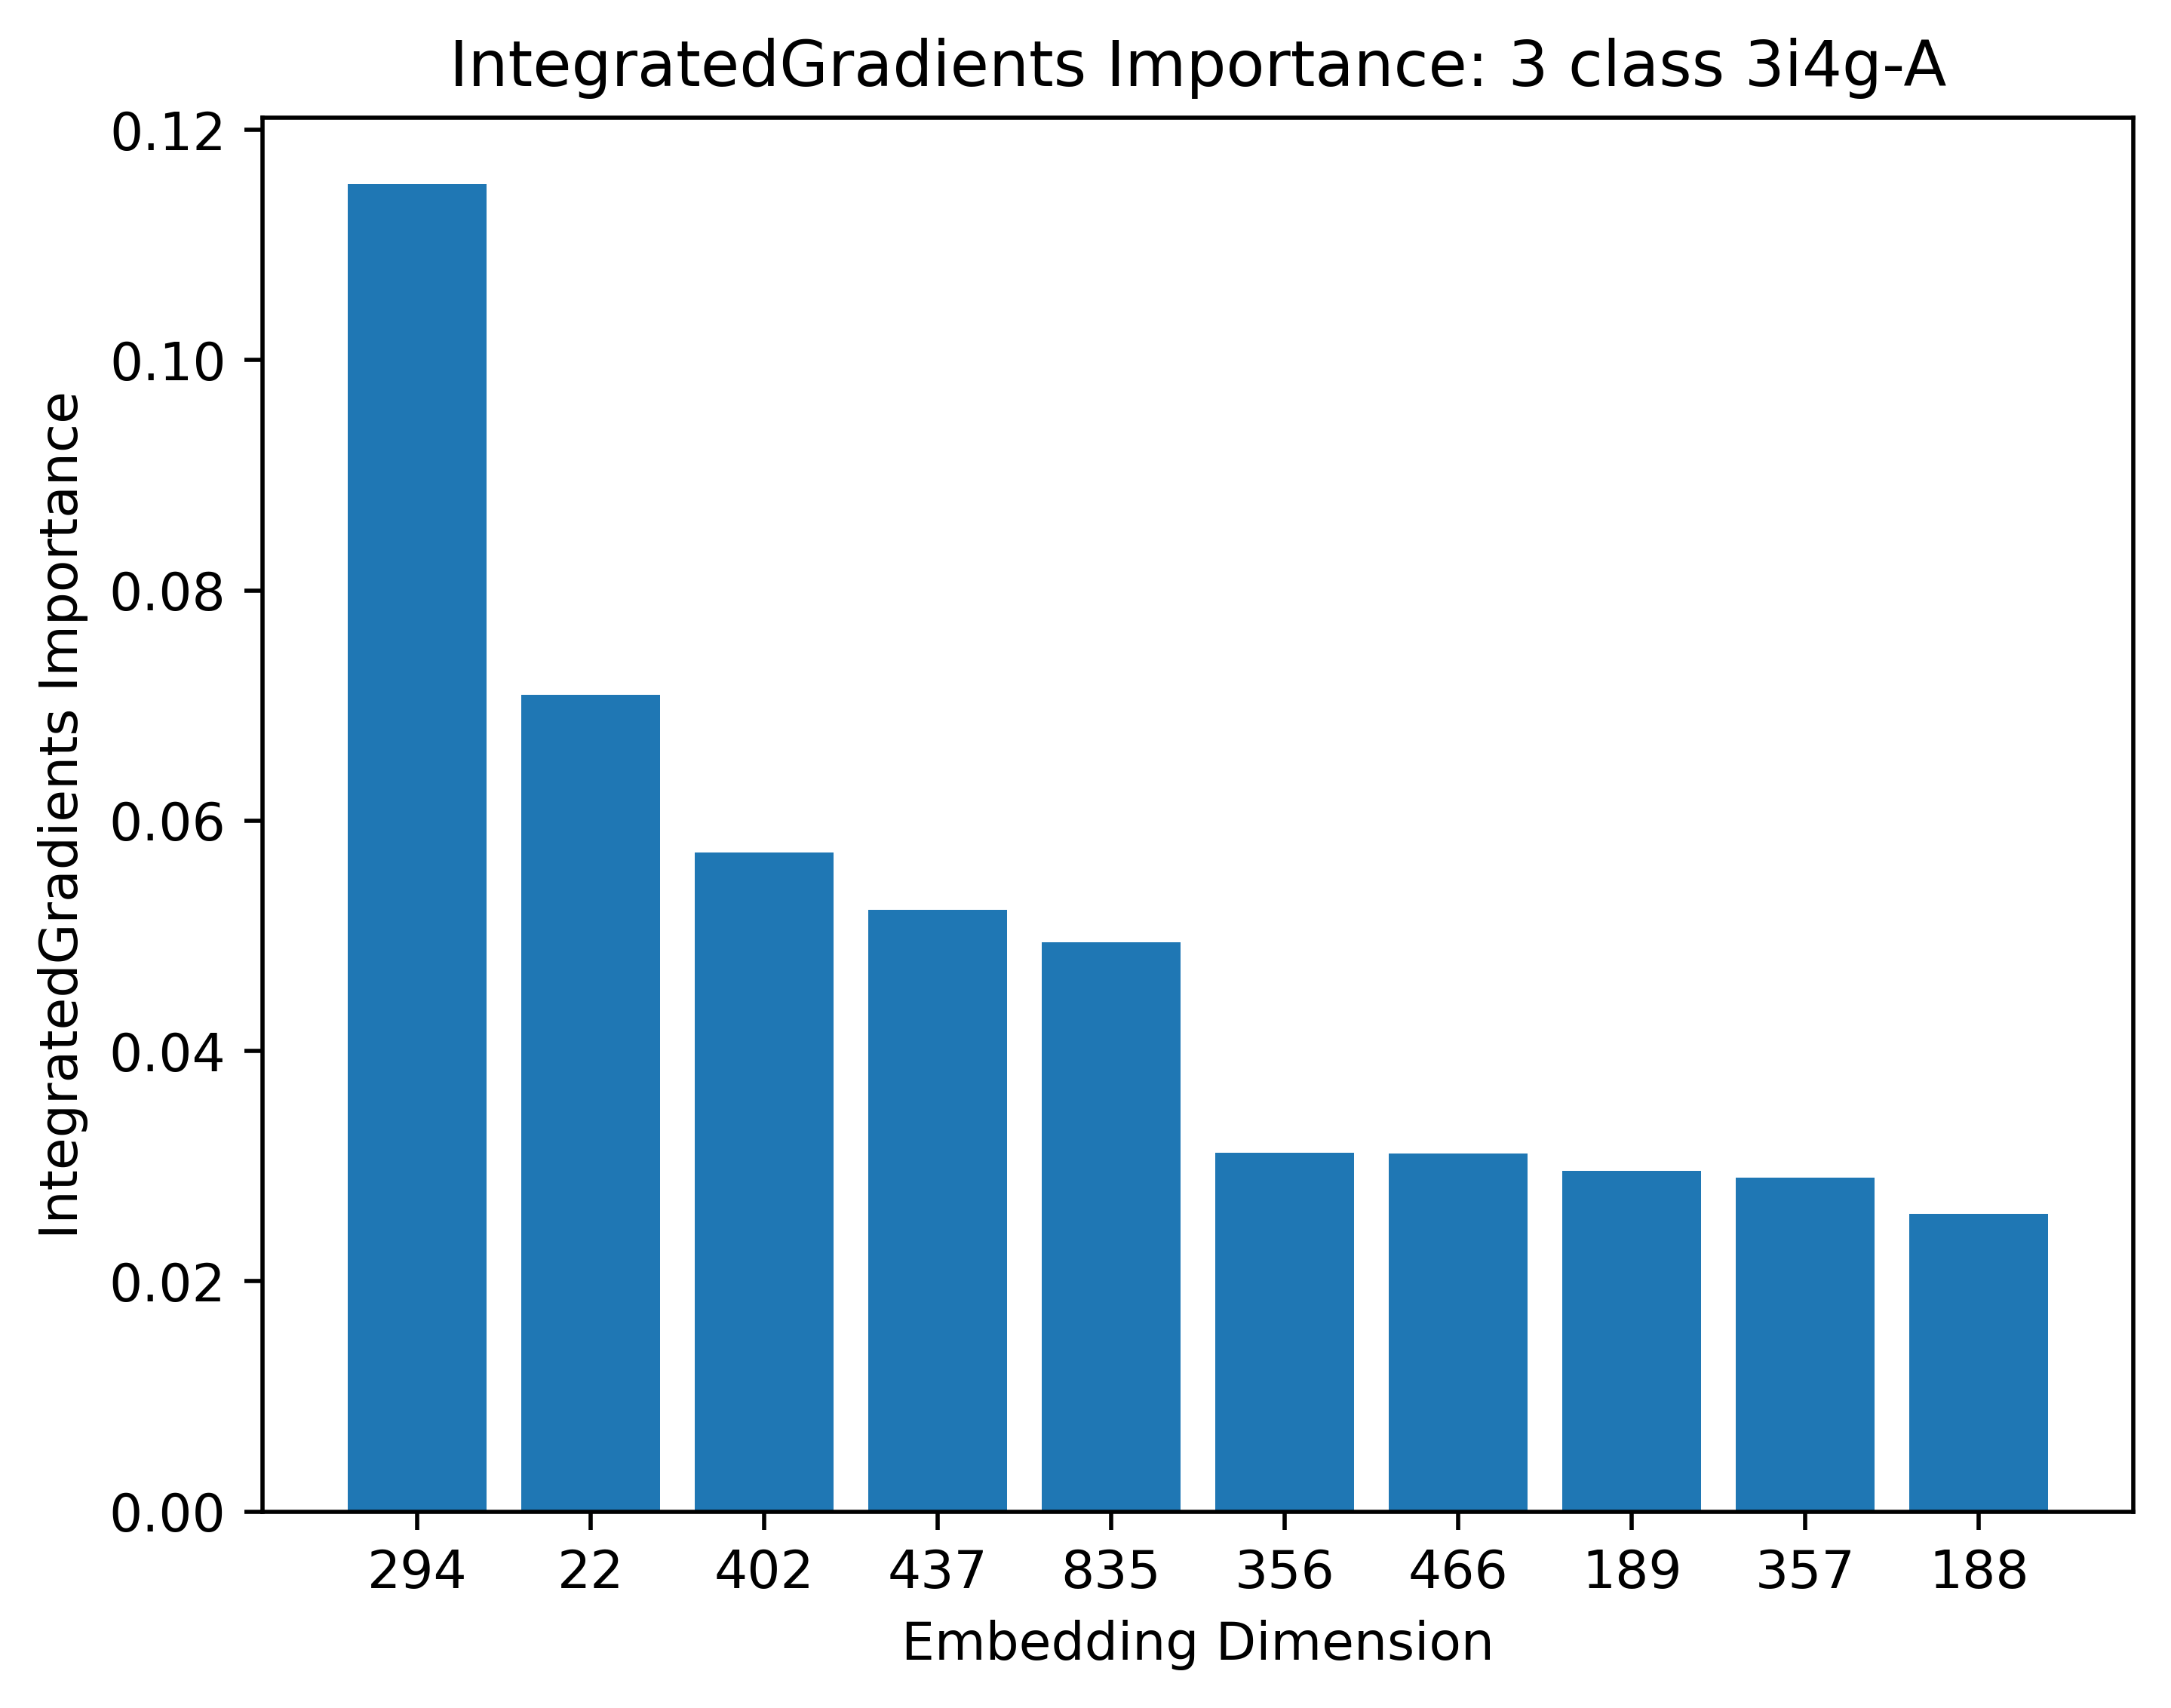

In [28]:
x_pos = np.arange(len(x))
plt.bar(x_pos, attr_mean[x], align='center')
plt.xticks(x_pos, x, wrap=True)
plt.xlabel('Embedding Dimension')
plt.ylabel('IntegratedGradients Importance')
plt.title('IntegratedGradients Importance: 3 class 3i4g-A')
plt.show()

### Feature Importance for 2 class Baseline Model

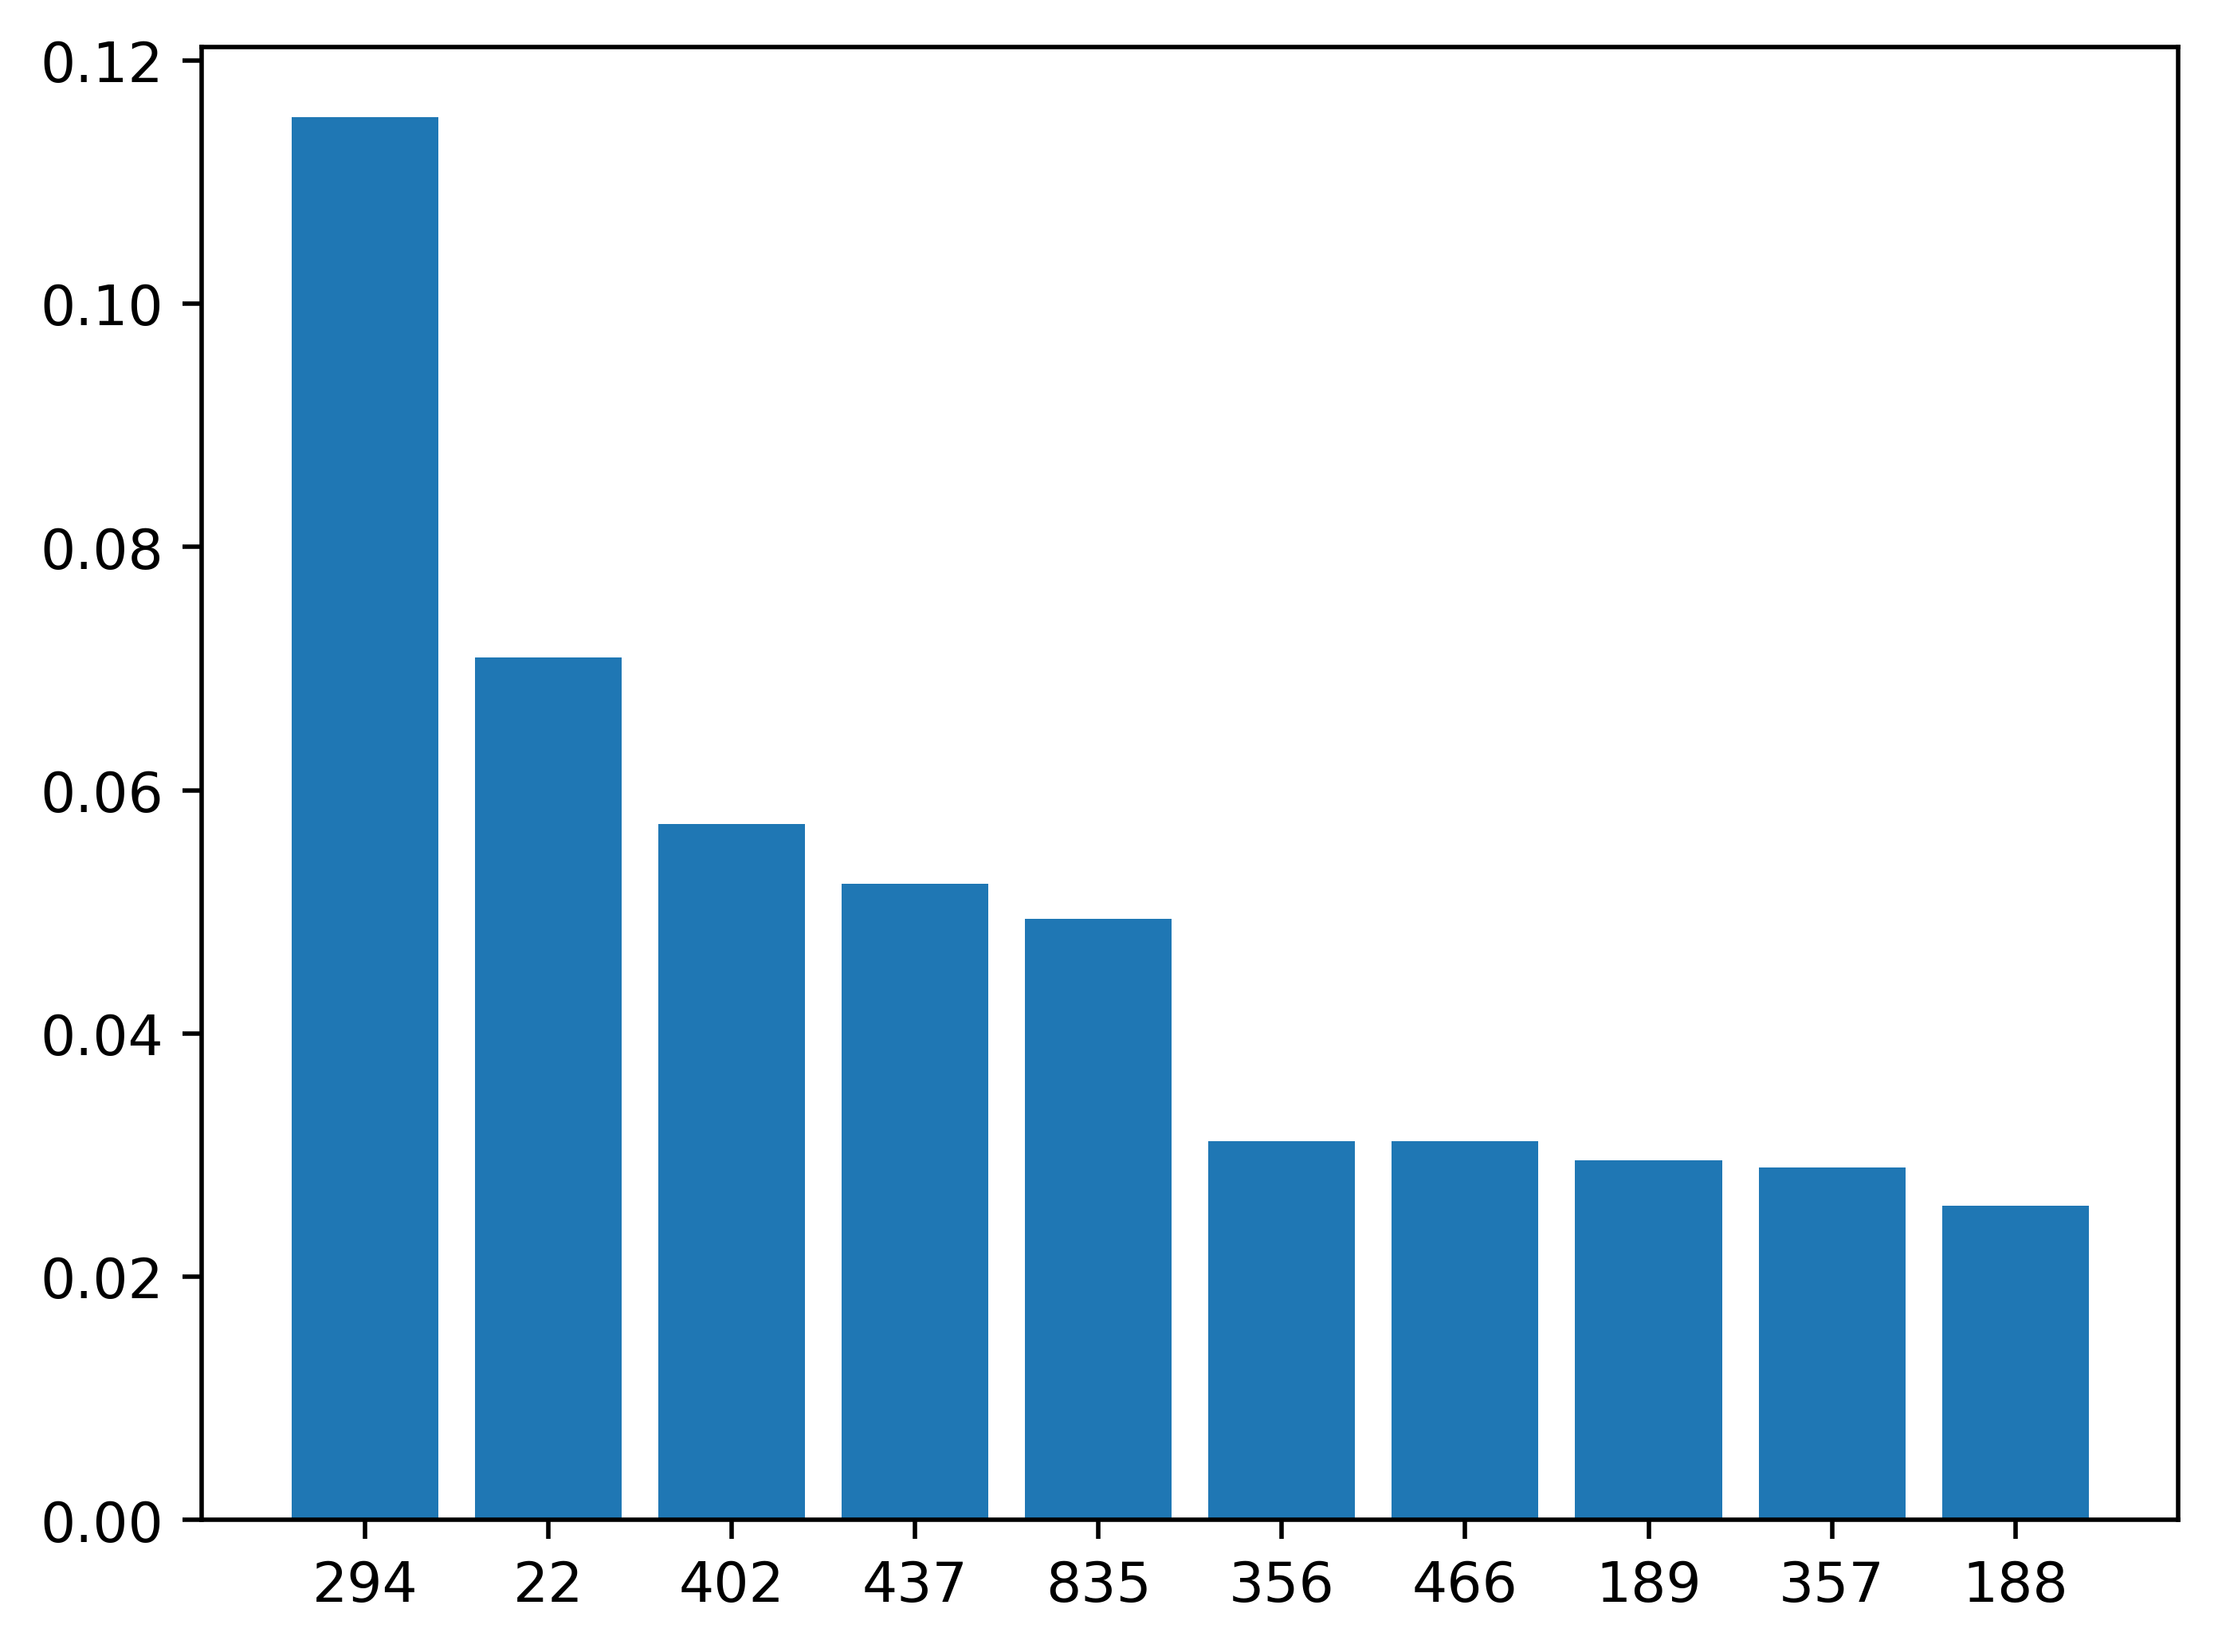

In [29]:
x_pos = np.arange(len(x))
plt.bar(x_pos, attr_mean[x], align='center')
plt.xticks(x_pos, x, wrap=True)
plt.title('IntegratedGradients Importance: 2 class 3i4g-A')
plt.show()